Neste colab, criaremos modelos epidemiológicos compartimentais através do epipack. \\
Para isso, é necessário instalar o epipack:

In [ ]:
pip install epipack

#1. Modelos

Nessa primeira parte, iremos apresentar e implementar variações do modelo SIR.

###Modelo SEIR

Começamos com um modelo SEIR, como mostra a figura abaixo.



SEIR.svg

Nesse modelo, a população é dividida em quatro compartimentos: 

- **S** é a fração de indivíduos suscetíveis (aqueles capazes de contrair a doença)
- **E** é a fração de indivíduos expostos (aqueles que foram infectados, mas ainda não são infecciosos)
- **I** é a fração de indivíduos infecciosos (aqueles capazes de transmitir a doença)
- **R** é a fração de indivíduos recuperados (aqueles que se tornaram imunes)

Ao terem contato com indivíduos infecciosos, os suscetíveis passam para o compartimento de expostos a uma **taxa de transmissão β**. Os expostos avançam para infecciosos a uma **taxa de progressão ω**. Os infecciosos se tornam recuperados a uma **taxa de recuperação γ**.

O tamanho da população é **N** e nesse modelo o tamanho é variável, pois há nascimento e morte. Novos indivíduos entram no compartimento de suscetíveis a uma **taxa de nascimento λ**. Indivíduos em todos os compartimentos são retirados do sistema a uma **taxa de morte natural μ**. Os infecciosos, além de terem uma taxa de morte natural, terão uma **taxa de morte causada pela doença σ**.

Para facilitar a leitura do código, em vez de utilizar nomes como *beta* ou *omega*, utilizaremos *transmission_rate* e *progression_rate*, assim é mais intuitivo o que cada variável representa. A tabela de equivalência entre as variáveis e seus símbolos é apresentada abaixo. As equivalências são mantidas em todos os modelos desse colab.

\\

| Taxa                            | Nome da variável   |
|---------------------------------|--------------------|
| Taxa de nascimento(λ)           | birth_rate         |
| Taxa de transmissão(β)          | transmission_rate  |
| Taxa de morte(μ)                | death_rate         |
| Taxa de morte pela doença(σ)    | disease_death_rate |
| Taxa de progressão da doença(ω) | progression_rate   |
| Taxa de recuperação(γ)          | recovery_rate      |

\\

Primeiro, importamos as bibliotecas que serão utilizadas e definimos as variáveis relacionadas aos compartimentos, taxas e população inicial. Faremos um modelo simbólico, então vamos utilizar o SymPy.

In [ ]:
from epipack import SymbolicEpiModel
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt

S, E, I, R = sy.symbols("S E I R")
birth_rate, death_rate, disease_death_rate = sy.symbols("lambda mu sigma")
transmission_rate, progression_rate, recovery_rate = sy.symbols("beta omega gamma")

N = 100000

Feito isso, podemos criar o modelo passando os compartimentos e o tamanho da população inicial. Ao criar o modelo, já são adicionados os processos que movem os indivíduos entre os compartimentos, de acordo com o que vimos na figura acima. Os processos são descritos como equações químicas.

In [ ]:
SEIR = SymbolicEpiModel([S,E,I,R], 
                        initial_population_size=N,
                        correct_for_dynamical_population_size=True
                       )\
    .set_processes([
        # None (birth_rate)-> S
        (None, birth_rate, S),

        # S + I (transmission_rate)-> E + I
        (S, I, transmission_rate, E, I),

        # S (death_rate)-> None
        (S, death_rate, None),

        # E (progression_rate)-> I
        (E, progression_rate, I),

        # E (death_rate)-> None
        (E, death_rate, None),

        # I (recovery_rate)-> R
        (I, recovery_rate, R),

        # I (death_rate)-> None
        (I, death_rate, None),

        # I (disease_death_rate)-> None
        (I, disease_death_rate, None),

        # R (death_rate)-> None
        (R, death_rate, None),
    ])

/usr/local/lib/python3.8/dist-packages/epipack/symbolic_epi_models.py:572: UserWarning: events do not sum to zero for each column:-E*mu - I*mu - I*sigma - R*mu - S*mu + lambda
  warnings.warn("events do not sum to zero for each column:" + str(test_sum))


Agora podemos dar valores aos parâmetros que fazem parte do sistema e dizer quais serão as condições iniciais dos compartimentos.

In [ ]:
SEIR.set_parameter_values({birth_rate: 0.00018,
                           transmission_rate: 0.3115, 
                           death_rate:0.00004563,
                           disease_death_rate:0.0018,
                           progression_rate:0.09,
                           recovery_rate:0.05
                          })

SEIR.set_initial_conditions({S: 98900, E: 1000, I: 100})

Por fim, vamos integrar o modelo para analisar os compartimentos em determinados pontos no tempo e plotar o resultado.

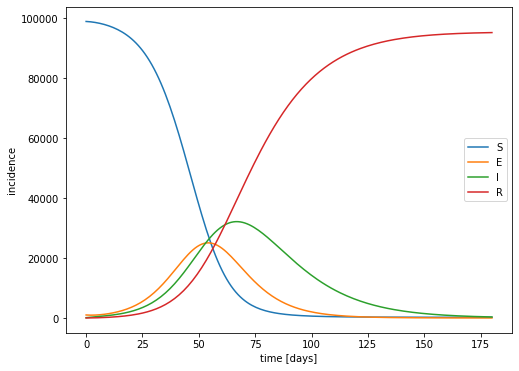

In [ ]:
t = np.linspace(0,180,180)
result = SEIR.integrate(t)

plt.figure(figsize=(8,6))
for compartment, incidence in result.items():
    plt.plot(t, incidence, label=compartment)

plt.xlabel('time [days]')
plt.ylabel('incidence')
plt.legend()
plt.show()

### Modelo SEQIR

No modelo SEQIR teremos a adição de um novo compartimento: quarentena. Agora, parte dos indivíduos expostos irão para quarentena a uma **taxa de quarentena φ**  e não infectarão os suscetíveis. A outra parte dos expostos não farão quarentena e vão para o compartimento dos infecciosos assim como no modelo anterior. Indivíduos em quarentena também contêm uma taxa de morte natural e uma taxa de morte causada pela doença.

SEQIR.svg

Temos uma nova variável nesse modelo, a relação entre símbolo e nome é apresentada na tabela abaixo.

\\

| Taxa                                 | Nome da variável   |
|--------------------------------------|--------------------|
| Taxa de quarentena(φ)                | quarantine_rate    |

\\

Para implementar e resolver esse sistema, fazemos o mesmo que foi feito no modelo SEIR, adicionando o novo compartimento e seus respectivos processos.

/usr/local/lib/python3.8/dist-packages/epipack/symbolic_epi_models.py:572: UserWarning: events do not sum to zero for each column:-E*mu - I*mu - I*sigma - Q*mu - Q*sigma - R*mu - S*mu + lambda
  warnings.warn("events do not sum to zero for each column:" + str(test_sum))


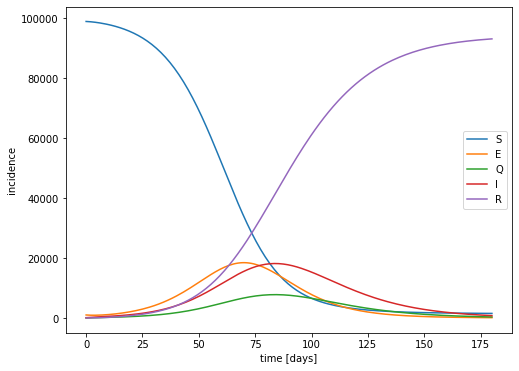

In [ ]:
S, E, Q, I, R = sy.symbols("S E Q I R")
birth_rate, death_rate, disease_death_rate = sy.symbols("lambda mu sigma")
transmission_rate, progression_rate, recovery_rate, quarantine_rate = sy.symbols("beta omega gamma phi")

N = 100000

SEQIR = SymbolicEpiModel([S,E,Q,I,R],
                         initial_population_size=N,
                         correct_for_dynamical_population_size=True
                        )\
    .set_processes([
        # None (birth_rate)-> S
        (None, birth_rate, S),

        # S + I (transmission_rate)-> E + I
        (S, I, transmission_rate, E, I),

        # S (death_rate)-> None
        (S, death_rate, None),

        # E ((1-quarantine_rate)*progression_rate)-> I
        (E, (1-quarantine_rate)*progression_rate, I),

        # E (quarantine_rate*progression_rate) -> Q
        (E, quarantine_rate*progression_rate, Q),

        # E (death_rate)-> None
        (E, death_rate, None),

        # I (recovery_rate)-> R
        (I, recovery_rate, R),

        # I (death_rate)-> None
        (I, death_rate, None),

        # I (disease_death_rate)-> None
        (I, disease_death_rate, None),

        # Q (death_rate)-> None
        (Q, death_rate, None),

        # Q (disease_death_rate)-> None
        (Q, disease_death_rate, None),

        # Q (recovery_rate)-> R
        (Q, recovery_rate, R),

        # R (death_rate)-> None
        (R, death_rate, None),
    ])

SEQIR.set_parameter_values({birth_rate: 0.00018,
                            transmission_rate: 0.3115, 
                            death_rate:0.00004563,
                            disease_death_rate:0.0018,
                            progression_rate:0.09,
                            recovery_rate:0.05,
                            quarantine_rate:0.3
                           })

SEQIR.set_initial_conditions({S: 98900, E: 1000, I: 100})

t = np.linspace(0,180,180)
result = SEQIR.integrate(t)

plt.figure(figsize=(8,6))
for compartment, incidence in result.items():
    plt.plot(t, incidence, label=compartment)

plt.xlabel('time [days]')
plt.ylabel('incidence')
plt.legend()
plt.show()

### Modelo SVEIR

No modelo SVEIR temos um compartimento de vacinados. Agora, os indivíduos suscetíveis são vacinados a uma **taxa de vacinação ζ**. Indivíduos vacinados ainda podem ser infectados e seguir o mesmo curso do modelo SEIR. Caso não sejam infectados, os vacinados passarão a ser recuperados a uma **taxa η**, que representa o tempo que leva para a vacina começar a ser eficaz.

SVEIR.svg

A relação entre os símbolos e os nomes das novas variáveis presentes nesse modelo é apresentada na tabela abaixo.

\\

| Taxa                                    | Nome da variável       |
|-----------------------------------------|------------------------|
| Taxa de vacinação(ζ)                    | vaccination_rate       |
| Início de eficácia da vacina(η)         | vaccine_efficacy_start |

\\

O modelo SVEIR também é implementado de maneira semelhante aos modelos anteriores, apenas ajustando os compartimentos e processos.

/usr/local/lib/python3.8/dist-packages/epipack/symbolic_epi_models.py:572: UserWarning: events do not sum to zero for each column:-E*mu - I*mu - I*sigma - R*mu - S*mu - V*mu + lambda
  warnings.warn("events do not sum to zero for each column:" + str(test_sum))


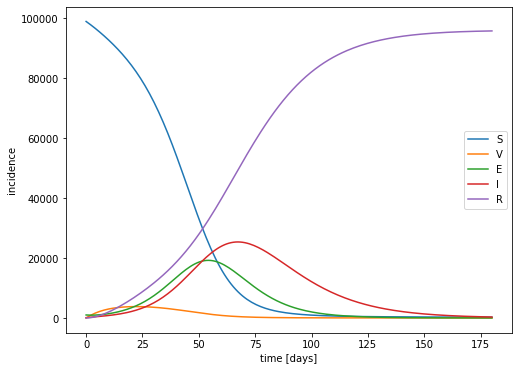

In [ ]:
S, V, E, I, R = sy.symbols("S V E I R")
birth_rate, death_rate, disease_death_rate = sy.symbols("lambda mu sigma")
transmission_rate, progression_rate, recovery_rate, vaccination_rate, vaccine_efficacy_start = sy.symbols("beta omega gamma zeta eta")

N = 100000

SVEIR = SymbolicEpiModel([S,V,E,I,R],
                         initial_population_size=N,
                         correct_for_dynamical_population_size=True
                        )\
    .set_processes([
        # None (birth_rate)-> S
        (None, birth_rate, S),

        # S + I (transmission_rate)-> E + I
        (S, I, transmission_rate, E, I),

        # S (vaccination_rate)-> V
        (S, vaccination_rate, V),

        # S (death_rate)-> None
        (S, death_rate, None),

        # E (progression_rate)-> I
        (E, progression_rate, I),

        # E (death_rate)-> None
        (E, death_rate, None),

        # V + I (transmission_rate)-> E + I
        (V, I, transmission_rate, E, I),

        # V (vaccine_efficacy_start)-> R
        (V, vaccine_efficacy_start, R),

        # V (death_rate)-> None
        (V, death_rate, None),

        # I (recovery_rate)-> R
        (I, recovery_rate, R),

        # I (death_rate)-> None
        (I, death_rate, None),

        # I (disease_death_rate)-> None
        (I, disease_death_rate, None),

        # R (death_rate)-> None
        (R, death_rate, None),
    ])

SVEIR.set_parameter_values({birth_rate: 0.00018,
                            transmission_rate: 0.3115, 
                            death_rate:0.00004563,
                            disease_death_rate:0.0018,
                            progression_rate:0.09,
                            recovery_rate:0.05,
                            vaccination_rate:0.005,
                            vaccine_efficacy_start:0.1
                           })

SVEIR.set_initial_conditions({S: 98900, E: 1000, I: 100})

t = np.linspace(0,180,180)
result = SVEIR.integrate(t)

plt.figure(figsize=(8,6))
for compartment, incidence in result.items():
    plt.plot(t, incidence, label=compartment)

plt.xlabel('time [days]')
plt.ylabel('incidence')
plt.legend()
plt.show()

### Modelo SEAIR

No modelo SEAIR parte dos indivíduos expostos irão para um compartimento de assintomáticos a uma **taxa de assintomáticos ρ**, o resto irá para o compartimento de infecciosos. Os assintomáticos também são infecciosos, porém não apresentam sintomas da doença. Da forma que implementamos o modelo, os assintomáticos transmitem, morrem ou se recuperam da doença com as mesmas taxas que os sintomáticos.

SEAIR.svg

A equivalência da nova variável é apresentada na tabela abaixo.

\\

| Taxa                                 | Nome da variável   |
|--------------------------------------|--------------------|
| Taxa de assintomáticos(ρ)            | asymptomatic_rate  |

\\

O código continua parecido, mudando apenas os compartimentos e processos necessários.

/usr/local/lib/python3.8/dist-packages/epipack/symbolic_epi_models.py:572: UserWarning: events do not sum to zero for each column:-A*mu - A*sigma - E*mu - I*mu - I*sigma - R*mu - S*mu + lambda
  warnings.warn("events do not sum to zero for each column:" + str(test_sum))


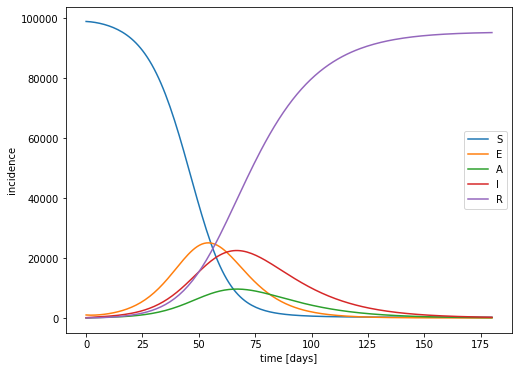

In [ ]:
S, E, A, I, R = sy.symbols("S E A I R")
birth_rate, death_rate, disease_death_rate = sy.symbols("lambda mu sigma")
transmission_rate, progression_rate, asymptomatic_rate, recovery_rate = sy.symbols("beta omega rho gamma")

N = 100000

SEAIR = SymbolicEpiModel([S,E,A,I,R],
                         initial_population_size=N,
                         correct_for_dynamical_population_size=True
                        )\
    .set_processes([
        # None (birth_rate)-> S
        (None, birth_rate, S),

        # S + I (transmission_rate)-> E + I
        (S, I, transmission_rate, E, I),

        # S + A (transmission_rate)-> E + A
        (S, A, transmission_rate, E, A),

        # S (death_rate)-> None
        (S, death_rate, None),

        # E ((1-asymptomatic_rate)*progression_rate)-> I
        (E, (1-asymptomatic_rate)*progression_rate, I),

        # E (asymptomatic_rate*progression_rate) -> A
        (E, asymptomatic_rate*progression_rate, A),

        # E (death_rate)-> None
        (E, death_rate, None),

        # I (recovery_rate)-> R
        (I, recovery_rate, R),

        # I (death_rate)-> None
        (I, death_rate, None),

        # I (disease_death_rate)-> None
        (I, disease_death_rate, None),

        # A (death_rate)-> None
        (A, death_rate, None),

        # A (disease_death_rate)-> None
        (A, disease_death_rate, None),

        # A (recovery_rate)-> R
        (A, recovery_rate, R),

        # R (death_rate)-> None
        (R, death_rate, None),
    ])

SEAIR.set_parameter_values({birth_rate: 0.00018,
                            transmission_rate: 0.3115, 
                            death_rate:0.00004563,
                            disease_death_rate:0.0018,
                            progression_rate:0.09,
                            recovery_rate:0.05,
                            asymptomatic_rate:0.3
                           })

SEAIR.set_initial_conditions({S: 98900, E: 1000, I: 100})

t = np.linspace(0,180,180)
result = SEAIR.integrate(t)

plt.figure(figsize=(8,6))
for compartment, incidence in result.items():
    plt.plot(t, incidence, label=compartment)

plt.xlabel('time [days]')
plt.ylabel('incidence')
plt.legend()
plt.show()

### Modelo SEIHR

No modelo SEIHR temos a adição do compartimento de hospitalizados. Nesse sistema, parte dos indivíduos infecciosos serão hospitalizados a uma **taxa de hospitalização χ**, o resto irá direto para o compartimento de recuperados. Os hospitalizados têm uma taxa de morte natural e uma taxa de morte causada pela doença. Eventualmente, os hospitalizados também se tornam recuperados.

SEIHR.svg

A equivalência da nova variável é apresentada na tabela abaixo.

\\

| Taxa                                 | Nome da variável     |
|--------------------------------------|----------------------|
| Taxa de hospitalização(χ)            | hospitalization_rate |

\\

Novamente, precisamos mudar apenas os compartimentos e processos.

/usr/local/lib/python3.8/dist-packages/epipack/symbolic_epi_models.py:572: UserWarning: events do not sum to zero for each column:-E*mu - H*mu - H*sigma - I*mu - I*sigma - R*mu - S*mu + lambda
  warnings.warn("events do not sum to zero for each column:" + str(test_sum))


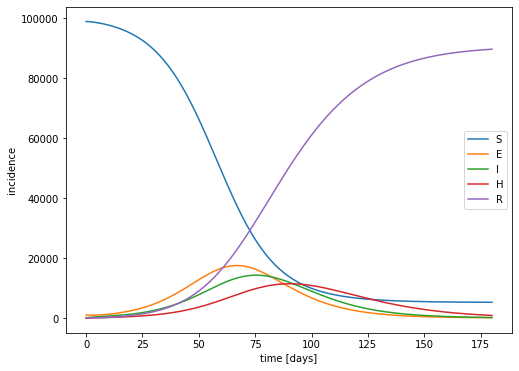

In [ ]:
S, E, I, H, R = sy.symbols("S E I H R")
birth_rate, death_rate, disease_death_rate = sy.symbols("lambda mu sigma")
transmission_rate, progression_rate, recovery_rate, hospitalization_rate = sy.symbols("beta omega gamma chi")

N = 100000

SEIHR = SymbolicEpiModel([S,E,I,H,R],
                         initial_population_size=N,
                         correct_for_dynamical_population_size=True
                        )\
    .set_processes([
        # None (birth_rate)-> S
        (None, birth_rate, S),

        # S + I (transmission_rate)-> E + I
        (S, I, transmission_rate, E, I),

        # S (death_rate)-> None
        (S, death_rate, None),

        # E (progression_rate)-> I
        (E, progression_rate, I),

        # E (death_rate)-> None
        (E, death_rate, None),

        # I (hospitalization_rate)-> H
        (I, hospitalization_rate, H),

        # I (recovery_rate)-> R
        (I, recovery_rate, R),

        # I (death_rate)-> None
        (I, death_rate, None),

        # I (disease_death_rate)-> None
        (I, disease_death_rate, None),

        # H (recovery_rate)-> R
        (H, recovery_rate, R),

        # H (death_rate)-> None
        (H, death_rate, None),

        # H (disease_death_rate)-> None
        (H, disease_death_rate, None),

        # R (death_rate)-> None
        (R, death_rate, None),
    ])

SEIHR.set_parameter_values({birth_rate: 0.00018,
                            transmission_rate: 0.3115, 
                            death_rate:0.00004563,
                            disease_death_rate:0.0018,
                            progression_rate:0.09,
                            recovery_rate:0.05,
                            hospitalization_rate:0.05
                           })

SEIHR.set_initial_conditions({S: 98900, E: 1000, I: 100})

t = np.linspace(0,180,180)
result = SEIHR.integrate(t)

plt.figure(figsize=(8,6))
for compartment, incidence in result.items():
    plt.plot(t, incidence, label=compartment)

plt.xlabel('time [days]')
plt.ylabel('incidence')
plt.legend()
plt.show()

# 2. Modelos de mini mundo

Agora podemos explorar os modelos de mini mundo. Nesses modelos consideramos múltiplos locais interligados. Cada local tem a sua própria população e modelo executando, e os habitantes podem migrar entre os diferentes locais.

O modelo que iremos executar em cada local será o modelo SEIR apresentado anteriormente. Para utilizar outras variações, basta ajustar os processos, compartimentos e variáveis.

Para representar as conexões entre os locais, utilizamos uma matriz de adjacência $\mathbf{A}$. Essa matriz indica que habitantes do local $\mathbf{i}$ migram para o local $\mathbf{j}$ a uma **taxa de migração** $\mathbf{A_{(i,j)}}$.

---
Vamos analisar três tamanhos de mini mundo:



**Um mini mundo com dois locais e conexão direta entre eles.**

2_places.svg

A matriz de adjacência que será utilizada nesse caso é apresentada abaixo. Caso queira experimentar o modelo com dois locais, execute o código no qual essa matriz é passada para a variável *links* e continue com a criação do modelo.

|    | L1    | L2    |
|----|-------|-------|
| **L1** | 0.0   | 0.002 |
| **L2** | 0.002 | 0.0   |

In [ ]:
links = [[0.0,0.002],
         [0.002,0.0]]

**Um mini mundo com 14 locais, no qual as conexões são feitas de acordo com as faces de um octaedro truncado. Na imagem abaixo, cada nó é um modelo SEIR.**

truncated_octahedron.svg

A matriz de adjacência que será utilizada nesse caso é apresentada abaixo. Caso queira experimentar o modelo com 14 locais, execute o código no qual essa matriz é passada para a variável links e continue com a criação do modelo.

|    | Q1      | Q2      | Q3      | Q4      | Q5      | Q6      | H1      | H2      | H3      | H4      | H5      | H6      | H7      | H8      |
|----|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| **Q1** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03888 | 0.00895 | 0.0     | 0.0     | 0.0     | 0.0     | 0.01714 | 0.02093 |
| **Q2** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03073 | 0.04948 | 0.00612 | 0.00985 | 0.0     | 0.0     | 0.0     | 0.0     |
| **Q3** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00094 | 0.04488 | 0.00189 | 0.02139 | 0.0     | 0.0     |
| **Q4** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00454 | 0.0     | 0.00213 | 0.0     | 0.01088 | 0.0     | 0.03758 | 0.0     |
| **Q5** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03498 | 0.0     | 0.04412 | 0.0     | 0.04604 | 0.0     | 0.04353 |
| **Q6** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.02025 | 0.02588 | 0.02334 | 0.04401 |
| **H1** | 0.03888 | 0.03073 | 0.0     | 0.00454 | 0.0     | 0.0     | 0.0     | 0.02586 | 0.02532 | 0.0     | 0.0     | 0.0     | 0.01706 | 0.0     |
| **H2** | 0.00895 | 0.04948 | 0.0     | 0.0     | 0.03498 | 0.0     | 0.02586 | 0.0     | 0.0     | 0.02197 | 0.0     | 0.0     | 0.0     | 0.04815 |
| **H3** | 0.0     | 0.00612 | 0.00094 | 0.00213 | 0.0     | 0.0     | 0.02532 | 0.0     | 0.0     | 0.01908 | 0.03875 | 0.0     | 0.0     | 0.0     |
| **H4** | 0.0     | 0.00985 | 0.04488 | 0.0     | 0.04412 | 0.0     | 0.0     | 0.02197 | 0.01908 | 0.0     | 0.0     | 0.03277 | 0.0     | 0.0     |
| **H5** | 0.0     | 0.0     | 0.00189 | 0.01088 | 0.0     | 0.02025 | 0.0     | 0.0     | 0.03875 | 0.0     | 0.0     | 0.02405 | 0.0239  | 0.0     |
| **H6** | 0.0     | 0.0     | 0.02139 | 0.0     | 0.04604 | 0.02588 | 0.0     | 0.0     | 0.0     | 0.03277 | 0.02405 | 0.0     | 0.0     | 0.00132 |
| **H7** | 0.01714 | 0.0     | 0.0     | 0.03758 | 0.0     | 0.02334 | 0.01706 | 0.0     | 0.0     | 0.0     | 0.0239  | 0.0     | 0.0     | 0.00843 |
| **H8** | 0.02093 | 0.0     | 0.0     | 0.0     | 0.04353 | 0.04401 | 0.0     | 0.04815 | 0.0     | 0.0     | 0.0     | 0.00132 | 0.00843 | 0.0     |

In [ ]:
links = [[0.0,0.0,0.0,0.0,0.0,0.0,0.03888,0.00895,0.0,0.0,0.0,0.0,0.01714,0.02093],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.03073,0.04948,0.00612,0.00985,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00094,0.04488,0.00189,0.02139,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.00454,0.0,0.00213,0.0,0.01088,0.0,0.03758,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03498,0.0,0.04412,0.0,0.04604,0.0,0.04353],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02025,0.02588,0.02334,0.04401],
         [0.03888,0.03073,0.0,0.00454,0.0,0.0,0.0,0.02586,0.02532,0.0,0.0,0.0,0.01706,0.0],
         [0.00895,0.04948,0.0,0.0,0.03498,0.0,0.02586,0.0,0.0,0.02197,0.0,0.0,0.0,0.04815],
         [0.0,0.00612,0.00094,0.00213,0.0,0.0,0.02532,0.0,0.0,0.01908,0.03875,0.0,0.0,0.0],
         [0.0,0.00985,0.04488,0.0,0.04412,0.0,0.0,0.02197,0.01908,0.0,0.0,0.03277,0.0,0.0],
         [0.0,0.0,0.00189,0.01088,0.0,0.02025,0.0,0.0,0.03875,0.0,0.0,0.02405,0.0239,0.0],
         [0.0,0.0,0.02139,0.0,0.04604,0.02588,0.0,0.0,0.0,0.03277,0.02405,0.0,0.0,0.00132],
         [0.01714,0.0,0.0,0.03758,0.0,0.02334,0.01706,0.0,0.0,0.0,0.0239,0.0,0.0,0.00843],
         [0.02093,0.0,0.0,0.0,0.04353,0.04401,0.0,0.04815,0.0,0.0,0.0,0.00132,0.00843,0.0]]

**Um mini mundo com 32 locais, no qual as conexões são feitas de acordo com as faces de uma bola de futebol (icosaedro truncado). Na imagem abaixo, cada nó é um modelo SEIR.**

truncated_icosahedron.svg

A matriz de adjacência que será utilizada nesse caso é apresentada abaixo. Caso queira experimentar o modelo com 32 locais, execute o código no qual essa matriz é passada para a variável links e continue com a criação do modelo.

|     | P1      | P2      | P3      | P4      | P5      | P6      | P7      | P8      | P9      | P10     | P11     | P12     | H1      | H2      | H3      | H4      | H5      | H6      | H7      | H8      | H9      | H10     | H11     | H12     | H13     | H14     | H15     | H16     | H17     | H18     | H19     | H20     |
|-----|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| **P1**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01329 | 0.02588 | 0.04568 | 0.0201  | 0.04735 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **P2**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04544 | 0.0     | 0.0     | 0.0     | 0.04432 | 0.00556 | 0.0     | 0.0     | 0.0     | 0.0387  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01243 | 0.0     |
| **P3**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01341 | 0.01397 | 0.0     | 0.0     | 0.0     | 0.04215 | 0.02937 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.02477 | 0.0     | 0.0     |
| **P4**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00858 | 0.0047  | 0.0     | 0.0     | 0.0     | 0.01151 | 0.03004 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04578 | 0.0     | 0.0     | 0.0     |
| **P5**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03802 | 0.02835 | 0.0     | 0.0     | 0.0     | 0.04027 | 0.01357 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01142 | 0.0     | 0.0     | 0.0     | 0.0     |
| **P6**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03669 | 0.03394 | 0.0     | 0.0     | 0.0     | 0.01871 | 0.032   | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00062 |
| **P7**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00044 | 0.01937 | 0.0446  | 0.00993 | 0.01079 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **P8**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04676 | 0.0     | 0.01353 | 0.0     | 0.0     | 0.0     | 0.03197 | 0.03476 | 0.0     | 0.0     | 0.0     | 0.03481 |
| **P9**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00209 | 0.0     | 0.0     | 0.0143  | 0.00722 | 0.0     | 0.0     | 0.0     | 0.00835 | 0.04493 | 0.0     | 0.0     | 0.0     |
| **P10** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0206  | 0.0     | 0.0     | 0.0     | 0.0     | 0.03979 | 0.0497  | 0.0     | 0.0     | 0.0     | 0.04169 | 0.01026 | 0.0     | 0.0     |
| **P11** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0122  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00741 | 0.01967 | 0.0     | 0.0     | 0.0     | 0.01221 | 0.0232  | 0.0     |
| **P12** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00433 | 0.0     | 0.0     | 0.0     | 0.02435 | 0.01875 | 0.0     | 0.0     | 0.0     | 0.04025 | 0.01115 |
| **H1**  | 0.01329 | 0.04544 | 0.01341 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.02614 | 0.0     | 0.0     | 0.04043 | 0.01029 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H2**  | 0.02588 | 0.0     | 0.01397 | 0.00858 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.02614 | 0.0     | 0.01061 | 0.0     | 0.0     | 0.0     | 0.01368 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H3**  | 0.04568 | 0.0     | 0.0     | 0.0047  | 0.03802 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01061 | 0.0     | 0.04634 | 0.0     | 0.0     | 0.0     | 0.04083 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H4**  | 0.0201  | 0.0     | 0.0     | 0.0     | 0.02835 | 0.03669 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04634 | 0.0     | 0.03228 | 0.0     | 0.0     | 0.0     | 0.04024 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H5**  | 0.04735 | 0.04432 | 0.0     | 0.0     | 0.0     | 0.03394 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04043 | 0.0     | 0.0     | 0.03228 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03584 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H6**  | 0.0     | 0.00556 | 0.04215 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0122  | 0.0     | 0.01029 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03419 | 0.02979 | 0.0     |
| **H7**  | 0.0     | 0.0     | 0.02937 | 0.01151 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0206  | 0.0     | 0.0     | 0.0     | 0.01368 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04814 | 0.01072 | 0.0     | 0.0     |
| **H8**  | 0.0     | 0.0     | 0.0     | 0.03004 | 0.04027 | 0.0     | 0.0     | 0.0     | 0.00209 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04083 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.035   | 0.01279 | 0.0     | 0.0     | 0.0     |
| **H9**  | 0.0     | 0.0     | 0.0     | 0.0     | 0.01357 | 0.01871 | 0.0     | 0.04676 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04024 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04717 | 0.0     | 0.0     | 0.0     | 0.00839 |
| **H10** | 0.0     | 0.0387  | 0.0     | 0.0     | 0.0     | 0.032   | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00433 | 0.0     | 0.0     | 0.0     | 0.0     | 0.03584 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04059 | 0.01169 |
| **H11** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00044 | 0.01353 | 0.0143  | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03258 | 0.0     | 0.0     | 0.03348 | 0.01935 | 0.0     | 0.0     | 0.0     | 0.0     |
| **H12** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01937 | 0.0     | 0.00722 | 0.03979 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03258 | 0.0     | 0.03749 | 0.0     | 0.0     | 0.0     | 0.00485 | 0.0     | 0.0     | 0.0     |
| **H13** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0446  | 0.0     | 0.0     | 0.0497  | 0.00741 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03749 | 0.0     | 0.01246 | 0.0     | 0.0     | 0.0     | 0.00933 | 0.0     | 0.0     |
| **H14** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00993 | 0.0     | 0.0     | 0.0     | 0.01967 | 0.02435 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01246 | 0.0     | 0.04919 | 0.0     | 0.0     | 0.0     | 0.01803 | 0.0     |
| **H15** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01079 | 0.03197 | 0.0     | 0.0     | 0.0     | 0.01875 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03348 | 0.0     | 0.0     | 0.04919 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03218 |
| **H16** | 0.0     | 0.0     | 0.0     | 0.0     | 0.01142 | 0.0     | 0.0     | 0.03476 | 0.00835 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.035   | 0.04717 | 0.0     | 0.01935 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H17** | 0.0     | 0.0     | 0.0     | 0.04578 | 0.0     | 0.0     | 0.0     | 0.0     | 0.04493 | 0.04169 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.04814 | 0.01279 | 0.0     | 0.0     | 0.0     | 0.00485 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H18** | 0.0     | 0.0     | 0.02477 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.01026 | 0.01221 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.03419 | 0.01072 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00933 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H19** | 0.0     | 0.01243 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0232  | 0.04025 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.02979 | 0.0     | 0.0     | 0.0     | 0.04059 | 0.0     | 0.0     | 0.0     | 0.01803 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **H20** | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00062 | 0.0     | 0.03481 | 0.0     | 0.0     | 0.0     | 0.01115 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.00839 | 0.01169 | 0.0     | 0.0     | 0.0     | 0.0     | 0.03218 | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |

In [ ]:
links = [[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01329,0.02588,0.04568,0.0201,0.04735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04544,0.0,0.0,0.0,0.04432,0.00556,0.0,0.0,0.0,0.0387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01243,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01341,0.01397,0.0,0.0,0.0,0.04215,0.02937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02477,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00858,0.0047,0.0,0.0,0.0,0.01151,0.03004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04578,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03802,0.02835,0.0,0.0,0.0,0.04027,0.01357,0.0,0.0,0.0,0.0,0.0,0.0,0.01142,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03669,0.03394,0.0,0.0,0.0,0.01871,0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00062],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00044,0.01937,0.0446,0.00993,0.01079,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04676,0.0,0.01353,0.0,0.0,0.0,0.03197,0.03476,0.0,0.0,0.0,0.03481],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00209,0.0,0.0,0.0143,0.00722,0.0,0.0,0.0,0.00835,0.04493,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0206,0.0,0.0,0.0,0.0,0.03979,0.0497,0.0,0.0,0.0,0.04169,0.01026,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0122,0.0,0.0,0.0,0.0,0.0,0.0,0.00741,0.01967,0.0,0.0,0.0,0.01221,0.0232,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00433,0.0,0.0,0.0,0.02435,0.01875,0.0,0.0,0.0,0.04025,0.01115],
         [0.01329,0.04544,0.01341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02614,0.0,0.0,0.04043,0.01029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.02588,0.0,0.01397,0.00858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02614,0.0,0.01061,0.0,0.0,0.0,0.01368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.04568,0.0,0.0,0.0047,0.03802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01061,0.0,0.04634,0.0,0.0,0.0,0.04083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0201,0.0,0.0,0.0,0.02835,0.03669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04634,0.0,0.03228,0.0,0.0,0.0,0.04024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.04735,0.04432,0.0,0.0,0.0,0.03394,0.0,0.0,0.0,0.0,0.0,0.0,0.04043,0.0,0.0,0.03228,0.0,0.0,0.0,0.0,0.0,0.03584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.00556,0.04215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0122,0.0,0.01029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03419,0.02979,0.0],
         [0.0,0.0,0.02937,0.01151,0.0,0.0,0.0,0.0,0.0,0.0206,0.0,0.0,0.0,0.01368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04814,0.01072,0.0,0.0],
         [0.0,0.0,0.0,0.03004,0.04027,0.0,0.0,0.0,0.00209,0.0,0.0,0.0,0.0,0.0,0.04083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035,0.01279,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.01357,0.01871,0.0,0.04676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04717,0.0,0.0,0.0,0.00839],
         [0.0,0.0387,0.0,0.0,0.0,0.032,0.0,0.0,0.0,0.0,0.0,0.00433,0.0,0.0,0.0,0.0,0.03584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04059,0.01169],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.00044,0.01353,0.0143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03258,0.0,0.0,0.03348,0.01935,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.01937,0.0,0.00722,0.03979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03258,0.0,0.03749,0.0,0.0,0.0,0.00485,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.0446,0.0,0.0,0.0497,0.00741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03749,0.0,0.01246,0.0,0.0,0.0,0.00933,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.00993,0.0,0.0,0.0,0.01967,0.02435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01246,0.0,0.04919,0.0,0.0,0.0,0.01803,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.0,0.01079,0.03197,0.0,0.0,0.0,0.01875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03348,0.0,0.0,0.04919,0.0,0.0,0.0,0.0,0.0,0.03218],
         [0.0,0.0,0.0,0.0,0.01142,0.0,0.0,0.03476,0.00835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035,0.04717,0.0,0.01935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.04578,0.0,0.0,0.0,0.0,0.04493,0.04169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04814,0.01279,0.0,0.0,0.0,0.00485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.02477,0.0,0.0,0.0,0.0,0.0,0.0,0.01026,0.01221,0.0,0.0,0.0,0.0,0.0,0.0,0.03419,0.01072,0.0,0.0,0.0,0.0,0.0,0.00933,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.01243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0232,0.04025,0.0,0.0,0.0,0.0,0.0,0.02979,0.0,0.0,0.0,0.04059,0.0,0.0,0.0,0.01803,0.0,0.0,0.0,0.0,0.0,0.0],
         [0.0,0.0,0.0,0.0,0.0,0.00062,0.0,0.03481,0.0,0.0,0.0,0.01115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00839,0.01169,0.0,0.0,0.0,0.0,0.03218,0.0,0.0,0.0,0.0,0.0]]

---
A partir da matriz, conseguimos calcular a quantidade de locais no nosso sistema. Aproveitamos para preencher listas com números aleatórios que representam quantos habitantes teremos em cada compartimento, para cada local. Após gerar as populações aleatórias, calculamos a população total do sistema.

In [ ]:
number_of_nodes = len(links)

amount_of_susceptible = [np.random.randint(3000,50000) for node in range(number_of_nodes)]
amount_of_exposed = [int(0.5*susceptible) for susceptible in amount_of_susceptible]
amount_of_infected = [int(0.15*exposed) for exposed in amount_of_exposed]

population_size = sum(amount_of_susceptible + amount_of_exposed + amount_of_infected)

Esse modelo também é numérico, então precisamos criar todas as variáveis utilizando o SymPy. Após criar as variáveis, são feitos dicionários utilizando os compartimentos e os números de habitantes gerados anteriormente. Isso serve para indicar a quantidade de habitantes em cada compartimento, para cada local. Esses dicionários serão as condições iniciais do nosso sistema.

In [ ]:
S = [sy.symbols("S" + str(node)) for node in range(number_of_nodes)]
E = [sy.symbols("E" + str(node)) for node in range(number_of_nodes)]
I = [sy.symbols("I" + str(node)) for node in range(number_of_nodes)]
R = [sy.symbols("R" + str(node)) for node in range(number_of_nodes)]
birth_rate, death_rate, disease_death_rate = sy.symbols("lambda mu sigma")
transmission_rate, progression_rate, recovery_rate = sy.symbols("beta omega gamma")

initial_conditions_S = dict(zip(S, amount_of_susceptible))
initial_conditions_E = dict(zip(E, amount_of_exposed))
initial_conditions_I = dict(zip(I, amount_of_infected))

Dependendo da quantidade de locais no sistema, escrever manualmente todos os processos é um trabalho extenso. Por isso, criamos uma lista vazia e iteramos por todos os locais, adicionando os processos de um modelo SEIR para cada local.

In [ ]:
processes = []

for node in range(number_of_nodes):
    processes.extend([
        # None (birth_rate)-> S[node]
        (None, birth_rate, S[node]),

        # S[node] + I[node] (transmission_rate)-> E[node] + I[node]
        (S[node], I[node], transmission_rate, E[node], I[node]),

        # S[node] (death_rate)-> None
        (S[node], death_rate, None),

        # E[node] (progression_rate)-> I
        (E[node], progression_rate, I[node]),

        # E[node] (death_rate)-> None
        (E[node], death_rate, None),

        # I[node] (recovery_rate)-> R[node]
        (I[node], recovery_rate, R[node]),

        # I[node] (death_rate)-> None
        (I[node], death_rate, None),

        # I[node] (disease_death_rate)-> None
        (I[node], disease_death_rate, None),

        # R[node] (death_rate)-> None
        (R[node], death_rate, None)
    ])

O mesmo é feito para adicionar os processos de migração entre locais. Percorremos pela matriz de adjacência e adicionamos os processos para cada compartimento, utilizando os índices e valores da matriz.

In [ ]:
migration_processes = []

for place_1, connections in enumerate(links):    
    for place_2, rate in enumerate(connections):
        if rate != 0:
            migration_processes.extend([
                # S[place_1] (rate)-> S[place_2]
                (S[place_1], rate, S[place_2]),

                # E[place_1] (rate)-> E[place_2]
                (E[place_1], rate, E[place_2]),

                # I[place_1] (rate)-> I[place_2]
                (I[place_1], rate, I[place_2]),

                # R[place_1] (rate)-> R[place_2]
                (R[place_1], rate, R[place_2])
            ])

Finalmente podemos criar o modelo passando os compartimentos, tamanho da população, processos e condições iniciais que foram geradas acima. Para isso, precisamos importar outra classe do epipack. Vamos colocar também os valores dos parâmetros que fazem parte do sistema. Da forma que foi implementado, todos os locais têm os mesmos parâmetros.

In [ ]:
from epipack import SymbolicMatrixEpiModel

SEIRmatrix = SymbolicMatrixEpiModel(S+E+I+R,
                                    initial_population_size=population_size,
                                    correct_for_dynamical_population_size=True
                                   )

SEIRmatrix.set_processes(processes + migration_processes)

SEIRmatrix.set_initial_conditions({**initial_conditions_S, **initial_conditions_E, **initial_conditions_I})

SEIRmatrix.set_parameter_values({progression_rate:0.09,
                                 recovery_rate:0.05,
                                 birth_rate:0.00018,
                                 death_rate:0.00004563,
                                 disease_death_rate:0.0018,
                                 transmission_rate:0.3115*(population_size/100000)
                                })

Agora basta integrar e plotar os resultados, como fizemos nos modelos anteriores.

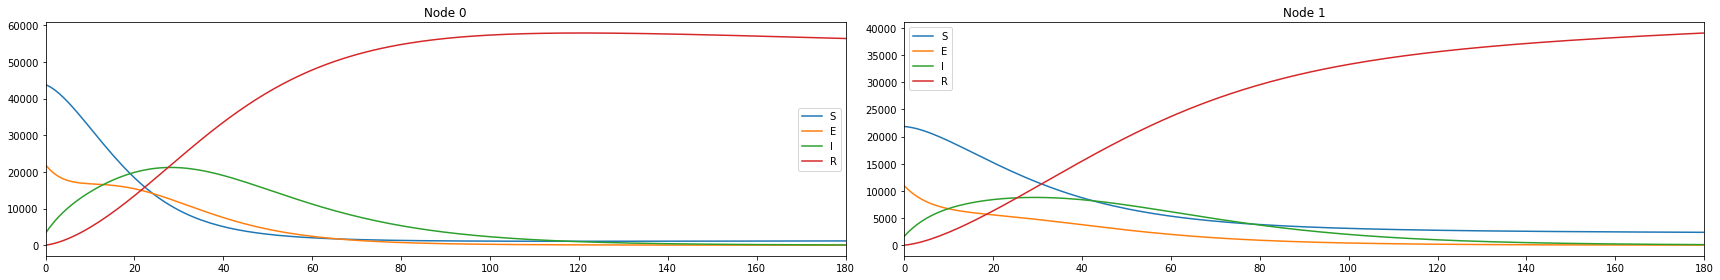

In [ ]:
t = np.linspace(0,180,180)
result = SEIRmatrix.integrate(t)

# plot result
import matplotlib.pyplot as plt

num_cols = 5

if number_of_nodes <= num_cols:
    num_rows = 1
    num_empty_axes = 0
    fig, ax = plt.subplots(1, number_of_nodes, figsize=(24,4))
else:
    num_rows = int(np.ceil(number_of_nodes/num_cols))
    num_empty_axes = (num_rows*num_cols) - number_of_nodes
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,4*num_rows))

for i in range(num_empty_axes):
    fig.delaxes(ax[num_rows-1][num_cols-1-i])

for compartment, concentration in result.items():
    node = int(str(compartment)[1:])

    if num_rows > 1:
        ax[int(node/num_cols)][node%num_cols].plot(t, concentration, label=str(compartment)[0])
    else:
        ax[node].plot(t, concentration, label=str(compartment)[0])


for node in range(number_of_nodes):
    if num_rows > 1:
        ax[int(node/num_cols)][node%num_cols].legend()
        ax[int(node/num_cols)][node%num_cols].set_title("Node " + str(node))
        ax[int(node/num_cols)][node%num_cols].set_xlim(xmin=0, xmax=180)
        ax[int(node/num_cols)][node%num_cols].set_ylim()
    else:
        ax[node].legend()
        ax[node].set_title("Node " + str(node))
        ax[node].set_xlim(xmin=0, xmax=180)
        ax[node].set_ylim()

plt.tight_layout()
plt.show()